# Import tabular data

The tabular data is imported. This contains information on whether several elements are present in the image, such as blur, a human, a group, etc. Also the pawpularity score of the training data is in the table. For the test data only the image ID and the features are in the table. There is also a sample submission table, which contains the pawpularity score for the test data.

In [ ]:
import pandas as pd

chdir("C:\\Users\\Cass Maes\\Documents\\PPP\\MinorAI\\ML_project\\CassBenteDemiIlse")

# import the CSV tables
csv_train_data = pd.read_csv("petfinder-pawpularity-score/train.csv")
csv_test_data = pd.read_csv("petfinder-pawpularity-score/test.csv")
sample_submission = pd.read_csv("petfinder-pawpularity-score/sample_submission.csv")
csv_train_data.head()

# Drop rows with missing values (if NaN values are in dataframe)
# no missing values present, so no samples dropped
csv_train_data.dropna()

csv_train_data['Pawpularity'] = csv_train_data['Pawpularity'] / 100
sample_submission['Pawpularity'] = sample_submission['Pawpularity'] / 100

# Processing tabular data

In [ ]:
# Select x-values (the 12 input features) from training data
x_train_tabular = csv_train_data.iloc[:,1:13].to_numpy()

# Select y-values (pawpularity) from training data
y_train_tabular = csv_train_data.iloc[:,13].to_numpy()

# Select x-values (12 input features) from testing data
x_test_tabular = csv_test_data.iloc[:,1:13].to_numpy()

# Select y-values (pawpularity) from testing data
y_test_tabular = sample_submission.iloc[:,1].to_numpy()

In [5]:
from tensorflow.keras import layers, models
from tensorflow.keras.losses import MeanSquaredError

def build_neural_net(input_size, hidden_nodes):
    """
    Build neural network with an input size and a hidden layer with a number of hidden nodes.
    """
    # Create a sequential model object
    model = models.Sequential()

    # Create the hidden layer with relu activations
    model.add(layers.Dense(units=hidden_nodes, activation='relu', input_shape=(input_size,)))
    
    # Create the output layer with 1 regression output unit
    model.add(layers.Dense(units=1))
    
    # Compile the network with the appropriate loss function
    model.compile(loss=MeanSquaredError())
    
    return model

# Create neural network for tabular data and get summary of model
tabular_NN = build_neural_net(12, 20)
tabular_NN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 20)                260       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 281
Trainable params: 281
Non-trainable params: 0
_________________________________________________________________


Train on 8920 samples, validate on 992 samples
Epoch 1/20
8920/8920 [==============================] - 1s 82us/sample - loss: 0.0582 - val_loss: 0.0427
Epoch 2/20
8920/8920 [==============================] - 0s 56us/sample - loss: 0.0441 - val_loss: 0.0432
Epoch 3/20
8920/8920 [==============================] - 1s 67us/sample - loss: 0.0435 - val_loss: 0.0414
Epoch 4/20
8920/8920 [==============================] - 0s 50us/sample - loss: 0.0431 - val_loss: 0.0414
Epoch 5/20
8920/8920 [==============================] - 1s 70us/sample - loss: 0.0431 - val_loss: 0.0418
Epoch 6/20
8920/8920 [==============================] - 0s 50us/sample - loss: 0.0430 - val_loss: 0.0417
Epoch 7/20
8920/8920 [==============================] - 1s 72us/sample - loss: 0.0430 - val_loss: 0.0420
Epoch 8/20
8920/8920 [==============================] - 1s 58us/sample - loss: 0.0429 - val_loss: 0.0414
Epoch 9/20
8920/8920 [==============================] - 1s 61us/sample - loss: 0.0427 - val_loss: 0.0412
Epoch 10

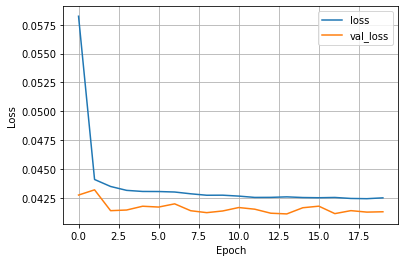

In [6]:
import matplotlib.pyplot as plt

# Part of code from: https://www.tensorflow.org/tutorials/keras/regression

# Train our model
history = tabular_NN.fit(x_train_tabular, y_train_tabular, batch_size=20, epochs=20, validation_split=.1)

# Store loss during training in DataFrame
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

def plot_loss(history):
    """
    Plot loss during epochs of training a neural network.
    """
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

plot_loss(history)

# See how the model scored
loss = tabular_NN.evaluate(x_test_tabular, y_test_tabular)

# Print to 3 decimals
print(f'Test loss: {loss:.3}')

# Import image data


In [7]:
from os import chdir, listdir
import matplotlib.pyplot as plt
import cv2

def reshape_images(path, n):
    """
    This function returns a list of images, which are reshaped to 64 x 64 
    and a list with the names of the images.
    """
    
    # set the current path
    chdir(path)
    
    # preset the lists
    images = []
    image_names = []
    
    # go over all the files in the path
    for i in listdir():
        
        # get the name of the image, without .jpg
        image_names.append(i[:-4])
        
        # get the image and reshape to n x n
        file = cv2.imread(i)
        file = cv2.resize(file,(n, n), interpolation=cv2.INTER_AREA)
        
        # rescale the pixels and store in the list
        images.append(file/255)
    
    # change directory back to main directory ("Fitgirls0011")
    chdir("../..")
        
    return images, image_names

train_imgs, train_names = reshape_images("petfinder-pawpularity-score/train", 64)
test_imgs, test_names = reshape_images("petfinder-pawpularity-score/test", 64)

# Combine tabular data with images

In [8]:
def merge_images(data, images, names):
    """
    This function merges the images to the corresponding row of the dataframe.
    """
    
    data['Image'] = ""
    
    # loop over all the names of the images
    for index_image, name_image in enumerate(names):
        
        # loop over all the names in the dataframe
        for index_csv, name_csv in enumerate(data['Id']):
            
            # if the names match, add the image to the row of the dataframe
            if name_image == name_csv:
                data['Image'][index_csv] = images[index_image]

    return data

In [9]:
def merge_images(data, images, names):
    """
    This function sorts the dataframe of the csv data according to the image names.
    """
    
    data_sorted = pd.DataFrame()

    for img, name in zip(images, names):
        location = data[data['Id'] == name].index[0]
        data_sorted = data_sorted.append([data.loc[location]])
        
    return data_sorted

train_data_sorted = merge_images(csv_train_data, train_imgs, train_names)
test_data_sorted = merge_images(csv_test_data, test_imgs, test_names)

In [10]:
sample_submission_sorted = merge_images(sample_submission, test_imgs, test_names)

In [11]:
# create new numpy arrays of sorted pawpularity scores
y_train_image = train_data_sorted['Pawpularity'].to_numpy()

y_test_image = sample_submission_sorted['Pawpularity'].to_numpy()


In [12]:
import numpy as np
# make numpy array of train images
train_imgs_array = np.array(train_imgs)

# display(train_imgs_array)

test_imgs_array = np.array(test_imgs)

In [14]:
import tensorflow as tf

def build_convol_net(image_size, hidden_nodes):
    """
    Build neural network with an input size and a hidden layer with a number of hidden nodes.
    """
    # Create a sequential model object
    model = models.Sequential()
    
    # Create convolutional layer 2 with relu activation
    model.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation='relu', input_shape=image_size, padding='same'))
    
    # Create a maxpool layer
    model.add(layers.MaxPool2D(pool_size=(2, 2), strides=2))
    
    # Create convolutional layer 2 with relu activation
    model.add(layers.Conv2D(filters = 128, kernel_size = (3,3), activation='relu', input_shape=image_size, padding='same'))

    # Create a maxpool layer
    model.add(layers.MaxPool2D(pool_size=(2, 2), strides=2))
    
    # Create a flattening layer
    model.add(layers.Flatten())

    # Create the hidden layer with relu activations
    model.add(layers.Dense(units=hidden_nodes, activation='relu', input_shape=(image_size,)))
    
    # Create the output layer with 1 sigmoid output unit
    model.add(layers.Dense(units=1, activation='sigmoid'))
    
    # Compile the network with the appropriate loss function
    model.compile(loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    return model

ERROR! Session/line number was not unique in database. History logging moved to new session 232


In [15]:
# Create neural network for image data and get summary of model
image_size = (64, 64, 3)
image_NN = build_convol_net(image_size, 20)
image_NN.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 20)                655380    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 20)                655380    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\bente\anaconda3\envs\progLab\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Public\Documents\Wondershare\CreatorTemp/ipykernel_12784/4040445920.py", line 33, in <module>
    print(f'Test loss: {loss:.3}')
TypeError: unsupported format string passed to list.__format__

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\bente\anaconda3\envs\progLab\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\bente\anaconda3\envs\progLab\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed

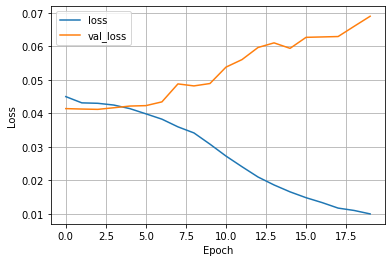

In [ ]:
# Create neural network for image data and get summary of model
image_size = (64, 64, 3)
image_NN = build_convol_net(image_size, 20)
image_NN.summary()

# Part of code from: https://www.tensorflow.org/tutorials/keras/regression

# Train our model
history = image_NN.fit(train_imgs_array, y_train_image, batch_size=20, epochs=20, validation_split=.1)

# Store loss during training in DataFrame
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

def plot_loss(history):
    """
    Plot loss during epochs of training a neural network.
    """
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

plot_loss(history)

# See how the model scored
loss = image_NN.evaluate(test_imgs_array, y_test_image)

# Print to 3 decimals
print(f'Test loss: {loss:.3}')

In [ ]:
from tensorflow.keras import layers, models, preprocessing

def train_and_evaluate(model, train_x, train_y, val_x, val_y, preprocess={}, epochs=20, augment={}):

#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    train_gen = preprocessing.image.ImageDataGenerator(**preprocess, **augment)
    train_gen.fit(train_x) 

    val_gen = preprocessing.image.ImageDataGenerator(**preprocess)
    val_gen.fit(train_x)
    
    history = model.fit(train_gen.flow(train_x, train_y), epochs=epochs, 
                        validation_data=val_gen.flow(val_x, val_y))

    fig, axs = plt.subplots(1,2,figsize=(20,5)) 

    for i, metric in enumerate(['loss', 'accuracy']):
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history['val_'+metric])
        axs[i].legend(['training', 'validation'], loc='best')

        axs[i].set_title('Model '+metric)
        axs[i].set_ylabel(metric)
        axs[i].set_xlabel('epoch')

    plt.show()
    
    print(f"Validation Accuracy: {model.evaluate(val_gen.flow(val_x, val_y))[1]}")
    
train_and_evaluate(image_NN, train_imgs_array, y_train_image, test_imgs_array, y_test_image,
                  preprocess = {'featurewise_center': True, 'featurewise_std_normalization': True})


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\bente\anaconda3\envs\progLab\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Public\Documents\Wondershare\CreatorTemp/ipykernel_12784/3982334932.py", line 31, in <module>
    train_and_evaluate(image_NN, train_imgs_array, y_train_image, test_imgs_array, y_test_image,
NameError: name 'image_NN' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\bente\anaconda3\envs\progLab\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\bente\anaconda3\envs\progLab\lib\site-packages\IPython\core\ultratb.py", li

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\bente\anaconda3\envs\progLab\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Public\Documents\Wondershare\CreatorTemp/ipykernel_12784/3982334932.py", line 31, in <module>
    train_and_evaluate(image_NN, train_imgs_array, y_train_image, test_imgs_array, y_test_image,
NameError: name 'image_NN' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\bente\anaconda3\envs\progLab\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\bente\anaconda3\envs\progLab\lib\site-packages\IPython\core\interactiveshel